In [47]:
import models
import utils
import torch
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

torch.manual_seed(42)
np.random.seed(42)

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

Y = torch.tensor(np.load('../datasets/floored_exp_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]
guess_prob = 1/5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infering parameters of sigmoid IRF

We first conduct coarse hyperparameter search and then train for a longer time on the optimal hyperparameters found on the search.

In [71]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-3,-1), 'reg':(-4,1)}, 10, 300, Y)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=34.77998816092339, reg=0.0015769192447197518, momentum=0


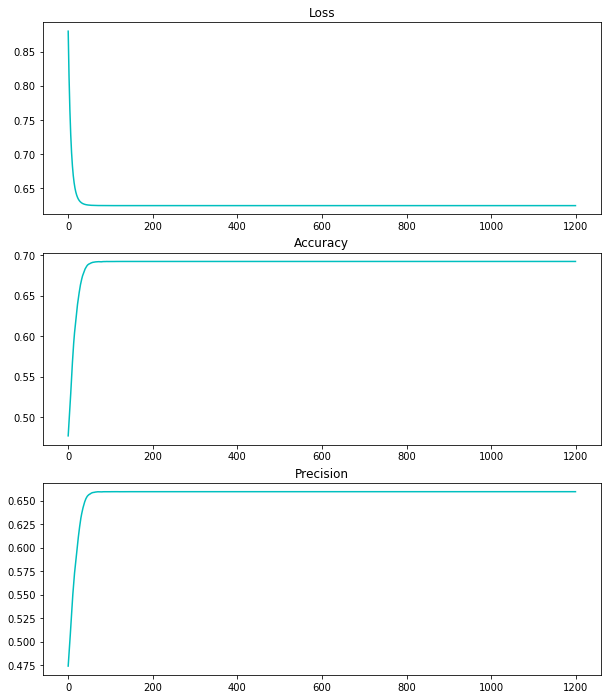

In [72]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=m)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, Y)
utils.plot_train_metrics(losses, train_acc, precision)

Here we calculate the RMSE between the inferred A and D matrices and their actual counterparts.

In [73]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(sigmoid_irf.A, torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(sigmoid_irf.D, torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.5347071290016174
RMSE(D, D_true) =  0.41756176948547363


For the sake of some exploration we compare the inferred models accuracy with the accuracy of the model using the actual A and D matrices. We also look at the scores distribution generated by the actual A and D matrices. As it turns out this distribution says a lot about the general behavior of the model, and explains why the (actual) floored exponential model attains higher accuracy on its own dataset than the does the (actual) sigmoid model on its dataset.

In [74]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Actual dist accuracy: ', torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Actual dist accuracy:  0.52457
Inferred model accuracy:  0.6921600103378296
Inferred model precision:  0.6596208810806274


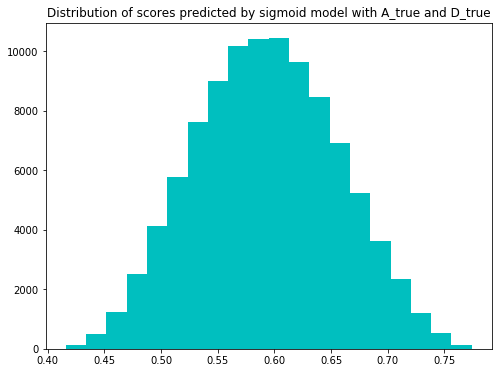

In [65]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid model with A_true and D_true')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Infering parameters of Floored exponential IRF

In [2]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-2), 'reg':(-3,1), 'momentum':(-1, 0)}, 10, 300, Y)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.0006796578090758152, reg=0.0012087541473056955, momentum=0.9330606024425664


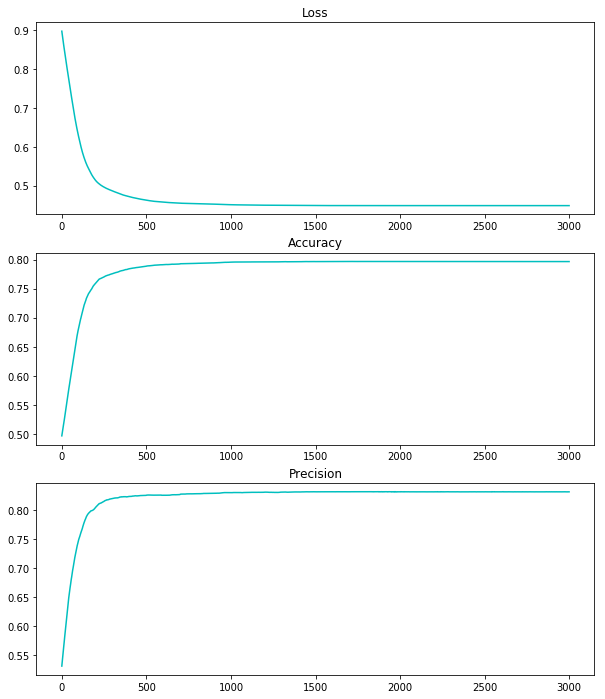

In [2]:
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob, 10)
optim = torch.optim.Adam(fe_irf.parameters(), lr=0.001, weight_decay=0)
losses, train_acc, precision = utils.train(fe_irf, optim, 3000, Y)
utils.plot_train_metrics(losses, train_acc, precision)

In [3]:
with torch.no_grad():
    print('Unaltered:')
    print('RMSE(A, A_true) = ', utils.rmse(fe_irf.A, torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(fe_irf.D, torch.tensor(D_true, dtype=dtype)))
    print('-----------------------------------')
    print('Clamped:')
    print('RMSE(A, A_true) = ', utils.rmse(fe_irf.A.clamp(0, 1), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(fe_irf.D.clamp(0, 1), torch.tensor(D_true, dtype=dtype)))
    print('-----------------------------------')
    print('Min-max normalized:')
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.D), torch.tensor(D_true, dtype=dtype)))

Unaltered:
RMSE(A, A_true) =  0.5018949508666992
RMSE(D, D_true) =  0.25337308645248413
-----------------------------------
Clamped:
RMSE(A, A_true) =  0.4657253324985504
RMSE(D, D_true) =  0.22713841497898102
-----------------------------------
Min-max normalized:
RMSE(A, A_true) =  0.20956598222255707
RMSE(D, D_true) =  0.5737402439117432


In [4]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Actual dist accuracy: ', torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Actual dist accuracy:  0.80246
Inferred model accuracy:  0.7965800166130066
Inferred model precision:  0.8320497870445251


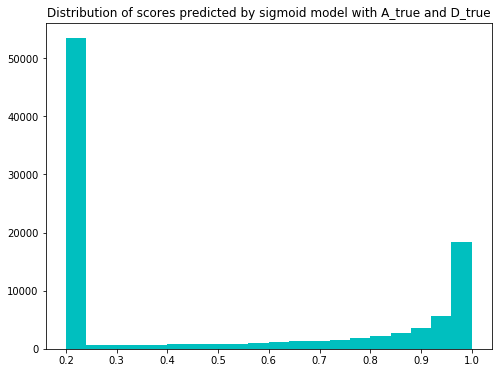

In [17]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid model with A_true and D_true')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

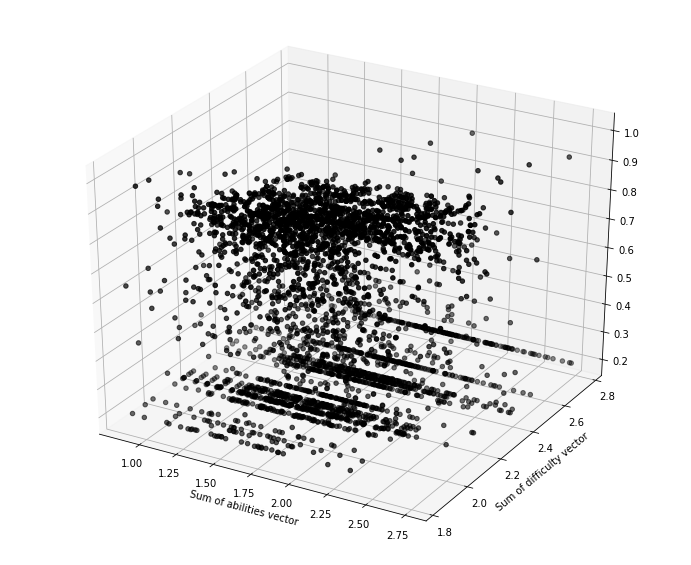

In [19]:
with torch.no_grad():
    outs = fe_irf(None)
    xs = []
    ys = []
    zs = []
    normed_A = utils.min_max_normalize(fe_irf.A)
    normed_D = utils.min_max_normalize(fe_irf.D)
    for i in range(0, outs.shape[0], 5):
        for j in range(0, outs.shape[1], 5):
            xs.append(torch.sum(normed_A[i]).item())
            ys.append(torch.sum(normed_D[j]).item())
            zs.append(outs[i,j].item())

    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='k')
    plt.xlabel('Sum of abilities vector')
    plt.ylabel('Sum of difficulty vector')
    plt.show()

In [21]:
torch.save(fe_irf, 'fe_irf_fe_correl.pt')